# Pytorch practice using CIFAR dataset

Loading packages.

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

import torch 
import torchvision # datasets
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 

Loading dataset and transforming data.

In [2]:
transform = transforms.Compose( 
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

batch_size = 4
num_workers = 2

# train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# there are 10 classes in CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's see some of pictures from dataset.

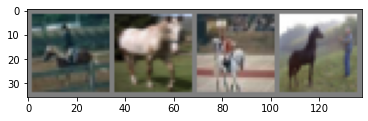

horse horse horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalizing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building and initializing CNN.

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

model = Network()

In [6]:
print(model)

Network(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2400, out_features=10, bias=True)
)


Defining loss function and optimizer.

In [7]:
from torch.optim import Adam
 
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

Defining training, accuracy testing and model saving functions.

In [8]:
from torch.autograd import Variable

# saving model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# testing the model with the test dataset and printing the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # running the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # computing the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We are looping over our data iterator and feeding the inputs to the network and optimizing.
def train(num_epochs):
    
    best_accuracy = 0.0

    # execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    model.to(device)

    for epoch in range(num_epochs): 
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(trainloader, 0):
            
            # getting the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zeroing the parameter gradients
            optimizer.zero_grad()
            # predicting classes using images from the training set
            outputs = model(images)
            # computing the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagating the loss
            loss.backward()
            # adjusting parameters based on the calculated gradients
            optimizer.step()

            # printing statistics for every 1,000 images
            running_loss += loss.item()     
            if i % 1000 == 999:     
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zeroing the loss
                running_loss = 0.0

        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # saving the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

Defining testing function.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def testBatch():
    images, labels = next(iter(testloader))

    imshow(torchvision.utils.make_grid(images))
   
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))

    outputs = model(images)
    
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

Training and testing the model.

The model will be running on cpu device
[1,  1000] loss: 1.054
[1,  2000] loss: 1.082
[1,  3000] loss: 1.087
[1,  4000] loss: 1.084
[1,  5000] loss: 1.060
[1,  6000] loss: 1.038
[1,  7000] loss: 1.101
[1,  8000] loss: 1.094
[1,  9000] loss: 1.067
[1, 10000] loss: 1.041
[1, 11000] loss: 1.045
[1, 12000] loss: 1.055
For epoch 1 the test accuracy over the whole test set is 65 %
[2,  1000] loss: 0.880
[2,  2000] loss: 0.848
[2,  3000] loss: 0.882
[2,  4000] loss: 0.864
[2,  5000] loss: 0.855
[2,  6000] loss: 0.872
[2,  7000] loss: 0.870
[2,  8000] loss: 0.845
[2,  9000] loss: 0.854
[2, 10000] loss: 0.836
[2, 11000] loss: 0.862
[2, 12000] loss: 0.845
For epoch 2 the test accuracy over the whole test set is 65 %
[3,  1000] loss: 0.851
[3,  2000] loss: 0.868
[3,  3000] loss: 0.857
[3,  4000] loss: 0.874
[3,  5000] loss: 0.875
[3,  6000] loss: 0.843
[3,  7000] loss: 0.832
[3,  8000] loss: 0.851
[3,  9000] loss: 0.868
[3, 10000] loss: 0.863
[3, 11000] loss: 0.866
[3, 12000] loss: 0.857
For epoc

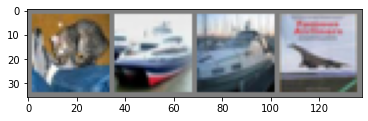

Real labels:    cat  ship  ship plane
Predicted:    cat  ship  bird plane


In [12]:
train(5)
print('Finished Training')

testAccuracy()

model = Network()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

testBatch()

After training for 5 epochs model shows 65% of accuracy. Training for more epochs can improve the results.